<a href="https://colab.research.google.com/github/nghthompson/Math_Clinic_Project/blob/main/Euler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The next code has a question for you, please answer to continue.

In [1]:
!pip uninstall matplotlib

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.3


In [2]:
%%capture
!pip install cpnet

In [3]:
%%capture
!pip install networkx numpy matplotlib==3.1.3 # Install the packages

In [4]:
import cpnet
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import os
import time
import zipfile
from tqdm import tqdm
import community.community_louvain as community
from numpy import *
import random
import requests
import json 
import datetime
###show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
url = 'https://raw.githubusercontent.com/nghthompson/Math_Clinic_Project/main/Euler%20Crypto%20Data.csv'
edf = pd.read_csv(url)

Now the notebook proceeds to clean the data.

In [6]:
edf.sort_values('block_timestamp', ascending = True)
edf.tail()

,token_address,from_address,to_address,block_timestamp,value
11367,0xd9fcd98c322942075a5c3860693e9f4f03aae07b,0x30741289523c2e4d2a62c7d6722686d14e723851,0x3bddcec392e54b303a42194fd57846d8df99b93e,2022-08-24 22:25:07.000,248867706360000000000
11368,0xd9fcd98c322942075a5c3860693e9f4f03aae07b,0xb003df4b243f938132e8cadbeb237abc5a889fb4,0x04352997a32e4fe761ee0ecfc1df50e485f2e78b,2022-08-24 22:46:59.000,40507338919512643982
11369,0xd9fcd98c322942075a5c3860693e9f4f03aae07b,0x30741289523c2e4d2a62c7d6722686d14e723851,0x61964babc2063480db1a606d5140185eb742e78e,2022-08-24 22:47:38.000,379586021880000000000
11370,0xd9fcd98c322942075a5c3860693e9f4f03aae07b,0x61964babc2063480db1a606d5140185eb742e78e,0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88,2022-08-24 22:50:47.000,379586021880000000000
11371,0xd9fcd98c322942075a5c3860693e9f4f03aae07b,0x30741289523c2e4d2a62c7d6722686d14e723851,0xd0be1fded5d964619b92b3672c08c43305529be0,2022-08-24 22:52:15.000,137354880950000000000


In [7]:
# data cleaning
edf.rename(columns={'f0_':'value'}, inplace = True)
edf = edf.dropna()
edf['value'] = edf['value'].apply(lambda x: float(x))
edf['timestamp'] = pd.to_datetime(edf['block_timestamp'])
edf['timestamp'] = edf['timestamp'].apply(lambda x: str(x)[:10])
edf['timestamp'] = pd.to_datetime(edf['timestamp'])


edf = edf[edf['timestamp']>='2021-12-30']
edf = edf[edf['timestamp']<='2022-08-24']


In [8]:
edf.to_csv('Euler Raw Transfer Data.csv')

In [9]:
edf = edf.drop(columns = ['token_address','block_timestamp'])

In [10]:
## add values between the 2 same addresses together
edf[['from_address', 'to_address']] = np.sort(edf[['from_address', 'to_address']], axis=1)
edf= edf.groupby(['timestamp','from_address','to_address']).agg(lambda x: sum(x)).reset_index()
#edf

In [11]:
edf.to_csv('Euler transaction data_after preprocessing.csv')

In [12]:
edf = pd.read_csv('Euler transaction data_after preprocessing.csv')

In [13]:
edf_time_partition= edf.groupby(['timestamp'])['to_address'].agg(['nunique']).reset_index()
edf_time_partition = edf_time_partition.drop(['nunique'], axis=1)

In [14]:
# Daily Network Building
import networkx as nx
num_nodes = []
num_edges = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Number of nodes, number of edges
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    num_nodes.append(nodes)
    num_edges.append(edges)

In [15]:
Network_Features={"num_nodes" : num_nodes,"num_edges" : num_edges}
Network_Features=pd.DataFrame(Network_Features)
Network_Features['time'] =  edf_time_partition['timestamp']

In [16]:
Degreemean = []
Degreestd = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Degree_centrality, mean_value
    degrees = G.degree()
    degree = list(dict(G.degree()).values())
    edf_deg = {"Degree" : degree}
    edf_deg = pd.DataFrame(edf_deg)
    DC_mean = edf_deg['Degree'].mean()
    DC_std = edf_deg['Degree'].std()
    Degreemean.append(DC_mean)
    Degreestd.append(DC_std)

In [17]:
Network_Features['Degree mean']  = Degreemean
Network_Features['Degree std']  = Degreestd

In [21]:
top10Degreemean = []
top10Degreestd = []

for i in range(0,len(edf_time_partition)):

    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    sender_mdegree= edf_1.groupby(['from_address'])['to_address'].count().reset_index()
    receiver_mdegree = edf_1.groupby(['to_address'])['from_address'].count().reset_index()
    sender_mdegree = sender_mdegree.rename(columns={'to_address':'degree'})
    sender_mdegree = sender_mdegree.rename(columns={'from_address':'address'})
    receiver_mdegree = receiver_mdegree.rename(columns = {'from_address':'degree'})
    receiver_mdegree = receiver_mdegree.rename(columns = {'to_address':'address'})

    merge = pd.merge(sender_mdegree,receiver_mdegree,on="address",how = "outer")
    merge = merge.fillna(int(0))
    merge['degree'] = merge['degree_x']+merge['degree_y']

    merge.sort_values(by=['degree'], ascending=False, inplace=True)
    merge = merge.reset_index()
    top5degree = merge['address'][0:10].tolist()

    sen_top =  edf_1[edf_1['from_address'].isin(top5degree)]
    rec_top= edf_1[edf_1['to_address'].isin(top5degree)]

    topaddress = pd.concat([sen_top,rec_top]).drop_duplicates()

    G = nx.from_pandas_edgelist(topaddress, 'from_address', 'to_address', 'value', nx.Graph())
    # Calculation of absolute degree
    degree = []
    for j in range (0,3): ## MUST CHANGE BACK TO (0,10) LATER. FIND OUT WHY top5degree IS ONLY THREE VARIABLES
        degrees = G.degree(top5degree[j])
        degree.append(degrees)
    edf_deg = {"Degree" : degree}
    edf_deg = pd.DataFrame(edf_deg)
    deg_mean = edf_deg['Degree'].mean()
    deg_std = edf_deg['Degree'].std()
    top10Degreemean.append(deg_mean)
    top10Degreestd.append(deg_std)

IndexError: ignored

In [ ]:
Network_Features['Top10Degree mean']  = top10Degreemean
Network_Features['Top10Degree std']  = top10Degreestd

In [ ]:
Network_Features['Top10 Degree mean ratio']  = Network_Features['Top10Degree mean']/Network_Features['Degree mean']

In [ ]:
DCmean = []
DCstd = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Degree_centrality, mean_value
    deg_cen = nx.degree_centrality(G)
    edf_deg = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Degree_Centrality'])
    DC_mean = edf_deg['Degree_Centrality'].mean()
    DC_std = edf_deg['Degree_Centrality'].std()
    DCmean.append(DC_mean)
    DCstd.append(DC_std)

In [ ]:
clustermean = []
clusterstd = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # Unweighted-Directed Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Clustering_Coefficient, mean_value, std
    clustering = nx.clustering(G)
    df_cluster = pd.DataFrame.from_dict(clustering, orient='index', columns=['Clustering_Coefficient'])
    cluster_mean = df_cluster['Clustering_Coefficient'].mean()
    cluster_std = df_cluster['Clustering_Coefficient'].std()
    clustermean.append(cluster_mean)
    clusterstd.append(cluster_std)

In [ ]:
mod_list = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of modularity
    part = community.best_partition(G)
    mod = community.modularity(part,G)
    mod_list.append(mod)

In [ ]:
tran_list = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # Unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of transitivity, 
    tran = nx.transitivity(G)
    tran_list.append(tran)

In [ ]:
eigmean = []
eigstd = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    #edf_1 = actsenrec.loc[actsenrec['timestamp']==edf_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Closeness_centrality, mean_value
    eig_cen = nx.eigenvector_centrality(G, max_iter=20000)
    edf_eig = pd.DataFrame.from_dict(eig_cen, orient='index', columns=['eigenvector_centrality'])
    eig_mean = edf_eig['eigenvector_centrality'].mean()
    eig_std = edf_eig['eigenvector_centrality'].std()
    eigmean.append(eig_mean)
    eigstd.append(eig_std)

In [ ]:
CCmean = []
CCstd = []
for i in range(0,len(edf_time_partition)):
    
    # Data Partition
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of Closeness_centrality, mean_value
    close_cen = nx.closeness_centrality(G)
    edf_close = pd.DataFrame.from_dict(close_cen, orient='index', columns=['Closeness_Centrality'])
    CC_mean = edf_close['Closeness_Centrality'].mean()
    CC_std = edf_close['Closeness_Centrality'].std()
    CCmean.append(CC_mean)
    CCstd.append(CC_std)

In [ ]:
components_cnt = []
for i in range(0,len(edf_time_partition)):
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    com_cnt = nx.number_connected_components(G)
    components_cnt.append(com_cnt)

In [ ]:
giant_com_ratio = []
for i in range(0,len(edf_time_partition)):
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
# G = nx.Graph()
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
#com_cnt = nx.number_connected_components(G)
#components_cnt.append(com_cnt)
    nodes = G0.number_of_nodes()
    nodes_whole = G.number_of_nodes()
    ratio = nodes/nodes_whole
    giant_com_ratio.append(ratio)

In [ ]:
Network_Features['DCmean']=DCmean
Network_Features['DCstd']=DCstd
Network_Features['clustermean']=clustermean
Network_Features['clusterstd']=clusterstd
Network_Features['modularity']=mod_list
Network_Features['transitivity']=tran_list
Network_Features['eig_mean']=eigmean
Network_Features['eig_std']=eigstd
Network_Features['closenessmean']=CCmean
Network_Features['closenessstd']=CCstd
Network_Features['Components_cnt']=components_cnt
Network_Features['giant_com_ratio']=giant_com_ratio

Network_Features['token'] =  'Euler'
#Network_Features

In [ ]:
Network_Features.to_csv('Euler_Network_Features.csv')

In [ ]:
edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][63]] 
G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    

alg = cpnet.BE()
alg.detect(G)
c = alg.get_pair_id()
x = alg.get_coreness()  # Get the coreness of nodes

##coreness = pd.DataFrame.from_dict(x, orient='index', columns=['Coreness'])
##corenessmean = coreness['Coreness'].mean()
#corenessmean

sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

In [ ]:
print(significant)
print(p_values)

In [ ]:
edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][63]] #64 was 90. Change later
G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of mean&std of coreness (continuous structure)
alg = cpnet.MINRES()
alg.detect(G)
x = alg.get_coreness() 
    
#coreness = pd.DataFrame.from_dict(x, orient='index', columns=['Coreness'])
#corenessmean = coreness['Coreness'].mean()
#corenessstd = coreness['Coreness'].std()
#print ('mean', corenessmean)
#print ('std', corenessstd)

sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, alg, significance_level=0.05, num_of_rand_net=100, num_of_thread=16)

In [ ]:
print(significant)
print(p_values)
print(sig_c)
print(sig_x)

In [ ]:
x = alg.get_coreness()  # Get the coreness of nodes
c = alg.get_pair_id()  # Get the group membership of nodes

In [ ]:
pos = nx.spiral_layout(G,scale = 1)
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
draw_nodes_kwd = {"node_size": 80, "linewidths": 0.8}
ax, pos = cpnet.utils.draw(G, sig_c, sig_x, ax, draw_nodes_kwd=draw_nodes_kwd) # layout_algorithm= {"verbose":True, "iterations":500})

In [ ]:
core_address = []
a = 0
for i in range(0,len(edf_time_partition)):
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()
    core_address.extend(core)
    a+=1
    #print(a)

In [ ]:
cores = pd.DataFrame(core_address)
core_cnt = cores[0].value_counts(ascending=False).reset_index()
core_cnt

In [ ]:
core_cnt.to_csv('core_date_cnt.csv')

In [ ]:
core_cnt = []
for i in range(0,len(edf_time_partition)):
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][i]]
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()
    cnt = len(core)
    core_cnt.append(cnt)

In [ ]:
avg_core_neighbor = []

for i in range(0,len(edf_time_partition)):
    edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][0]]
    G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
    alg = cpnet.BE()
    alg.detect(G)
    c = alg.get_pair_id()
    x = alg.get_coreness()

    coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
    core = coredf[coredf['coreness']==1].index.tolist()

    neighbor_cnt = []
    for i in range (0,len(core)):
        neighbor = G.degree(core[i])
        neighbor_cnt.append(neighbor)
    
    neighbor_cnt_mean = mean(neighbor_cnt)
    avg_core_neighbor.append(neighbor_cnt_mean)

In [ ]:
Network_Features = pd.read_csv('Euler_Network_Features.csv')
Network_Features['core_cnt']=core_cnt
Network_Features['core_ratio']=Network_Features['core_cnt']/Network_Features['num_nodes']
Network_Features['avg_core_neighbor']=avg_core_neighbor

In [ ]:
Network_Features.to_csv('Euler_Network_Features.csv')

In [ ]:
firstmonth  = edf_time_partition.iloc[31:62]
secondmonth = edf_time_partition.iloc[62:94]
secondmonth = secondmonth.reset_index()

df_1month = edf[edf['timestamp'].isin(firstmonth['timestamp'])]
df_2month = edf[edf['timestamp'].isin(secondmonth['timestamp'])]

sender_mdegree= df_1month.groupby(['from_address'])['to_address'].count().reset_index()
receiver_mdegree = df_1month.groupby(['to_address'])['from_address'].count().reset_index()
sender_mdegree = sender_mdegree.rename(columns={'to_address':'degree'})
sender_mdegree = sender_mdegree.rename(columns={'from_address':'address'})
receiver_mdegree = receiver_mdegree.rename(columns = {'from_address':'degree'})
receiver_mdegree = receiver_mdegree.rename(columns = {'to_address':'address'})

merge = pd.merge(sender_mdegree,receiver_mdegree,on="address",how = "outer")
merge = merge.fillna(int(0))
merge['degree'] = merge['degree_x']+merge['degree_y']

In [ ]:
df_sender_txval_tot = df_1month.groupby(['from_address'])['value'].sum().reset_index()
df_receiver_txval_tot = df_1month.groupby(['to_address'])['value'].sum().reset_index()
df_sender_txval_tot = df_sender_txval_tot.rename(columns={'from_address':'address'})
df_receiver_txval_tot = df_receiver_txval_tot.rename(columns={'to_address':'address'})

merge_tx = pd.merge(df_sender_txval_tot,df_receiver_txval_tot,on="address",how = "outer")
merge_tx = merge_tx.fillna(int(0))
merge_tx['value'] = merge_tx['value_x']+merge_tx['value_y']

In [ ]:
top5perct_rdegree = merge['degree'].quantile(0.95)
top5_address_degree = merge[merge['degree']>=top5perct_rdegree]
top5perct_tx = merge_tx['value'].quantile(0.95)
top5_address_tx = merge_tx[merge_tx['value']>=top5perct_tx]

top5_address = pd.merge(top5_address_degree,top5_address_tx,how='inner',on="address")

In [ ]:
sender_remove = df_2month[~df_2month['from_address'].isin(top5_address['address'])]
allremove = sender_remove[~sender_remove['to_address'].isin(top5_address['address'])]

In [ ]:
address_remove = merge.sample(n=int(0.05*len(merge)), replace=False, axis=0)
sen_ar = df_2month[~df_2month['from_address'].isin(address_remove['address'])]
senrec_ar= sen_ar[~sen_ar['to_address'].isin(address_remove['address'])]
senrec_ar = senrec_ar.reset_index()

In [ ]:
edf_1 = edf.loc[edf['timestamp']==edf_time_partition['timestamp'][2]]
G = nx.from_pandas_edgelist(edf_1, 'from_address', 'to_address', 'value', nx.Graph())
alg = cpnet.BE()
alg.detect(G)
c = alg.get_pair_id()
x = alg.get_coreness()

coredf = pd.DataFrame.from_dict(x, orient='index',columns=['coreness'])
core = coredf[coredf['coreness']==1].index.tolist()
core

sen_periphery =  df_2month[~df_2month['from_address'].isin(core)]
senrec_periphery= sen_periphery[~sen_periphery['to_address'].isin(core)]
senrec_periphery = senrec_periphery.reset_index()
senrec_periphery

# Network Visualization

In [ ]:
edf

In [22]:
# Number Wallet IDs for simplification

unique_addresses = set(edf['from_address'].unique()) | set(edf['to_address'].unique())
mapping = {address: n for n, address in enumerate(unique_addresses)}

edf[['from_ID', 'to_ID']] = edf[['from_address', 'to_address']].replace(mapping)

In [28]:
# breakdown dataframe into weeks and months

june = edf[(edf.timestamp >= '2022-06-01') & (edf.timestamp <= '2022-06-30')]
july = edf[(edf.timestamp >= '2022-07-01') & (edf.timestamp <= '2022-07-31')]
august = edf[(edf.timestamp >= '2022-08-01') & (edf.timestamp <= '2022-08-31')]
week1 = edf[(edf.timestamp >= '2022-06-19') & (edf.timestamp <= '2022-06-25')]
week2 = edf[(edf.timestamp >= '2022-06-26') & (edf.timestamp <= '2022-07-02')]
week3 = edf[(edf.timestamp >= '2022-07-03') & (edf.timestamp <= '2022-07-09')]
week4 = edf[(edf.timestamp >= '2022-07-10') & (edf.timestamp <= '2022-07-16')]
week5 = edf[(edf.timestamp >= '2022-07-17') & (edf.timestamp <= '2022-07-23')]
week6 = edf[(edf.timestamp >= '2022-07-24') & (edf.timestamp <= '2022-07-30')]
week7 = edf[(edf.timestamp >= '2022-07-31') & (edf.timestamp <= '2022-08-06')]
week8 = edf[(edf.timestamp >= '2022-08-07') & (edf.timestamp <= '2022-08-13')]
week9 = edf[(edf.timestamp >= '2022-08-14') & (edf.timestamp <= '2022-08-20')]
week10 = edf[(edf.timestamp >= '2022-08-21') & (edf.timestamp <= '2022-08-27')]

In [30]:
all_time = nx.from_pandas_edgelist(edf, source='from_ID', target='to_ID', edge_attr='value')
june = nx.from_pandas_edgelist(june, source='from_ID', target='to_ID', edge_attr='value')
july = nx.from_pandas_edgelist(july, source='from_ID', target='to_ID', edge_attr='value')
august = nx.from_pandas_edgelist(august, source='from_ID', target='to_ID', edge_attr='value')
week1 = nx.from_pandas_edgelist(week1, source='from_ID', target='to_ID', edge_attr='value')
week2 = nx.from_pandas_edgelist(week2, source='from_ID', target='to_ID', edge_attr='value')
week3 = nx.from_pandas_edgelist(week3, source='from_ID', target='to_ID', edge_attr='value')
week4 = nx.from_pandas_edgelist(week4, source='from_ID', target='to_ID', edge_attr='value')
week5 = nx.from_pandas_edgelist(week5, source='from_ID', target='to_ID', edge_attr='value')
week6 = nx.from_pandas_edgelist(week6, source='from_ID', target='to_ID', edge_attr='value')
week7 = nx.from_pandas_edgelist(week7, source='from_ID', target='to_ID', edge_attr='value')
week8 = nx.from_pandas_edgelist(week8, source='from_ID', target='to_ID', edge_attr='value')
week9 = nx.from_pandas_edgelist(week9, source='from_ID', target='to_ID', edge_attr='value')
week10 = nx.from_pandas_edgelist(week10, source='from_ID', target='to_ID', edge_attr='value')

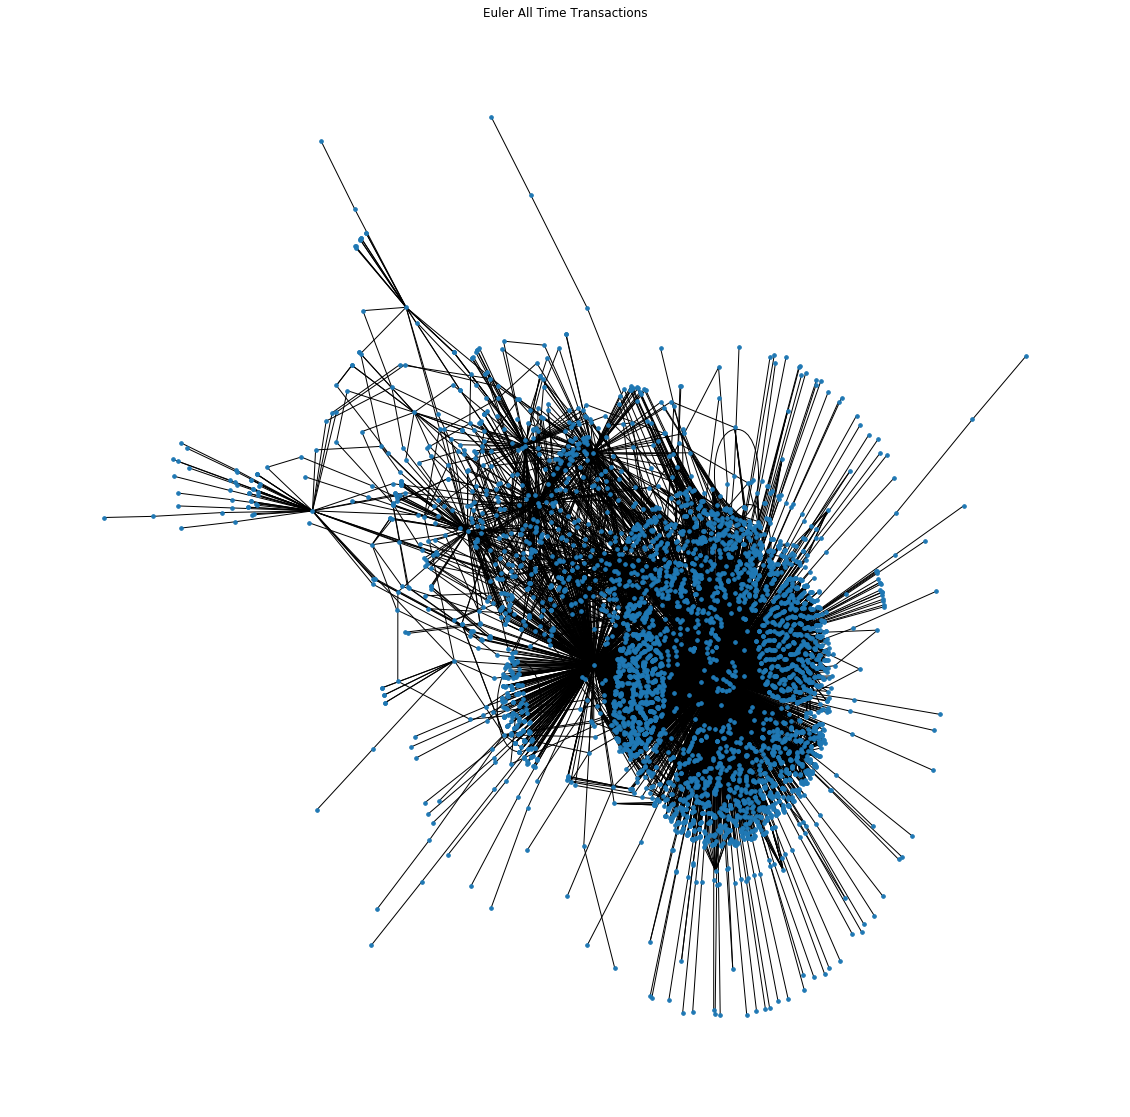

In [25]:
#network of all transactions

plt.figure(figsize=(20, 20))
plt.title('Euler All Time Transactions')
nx.draw(all_time, with_labels=False, node_size=13)

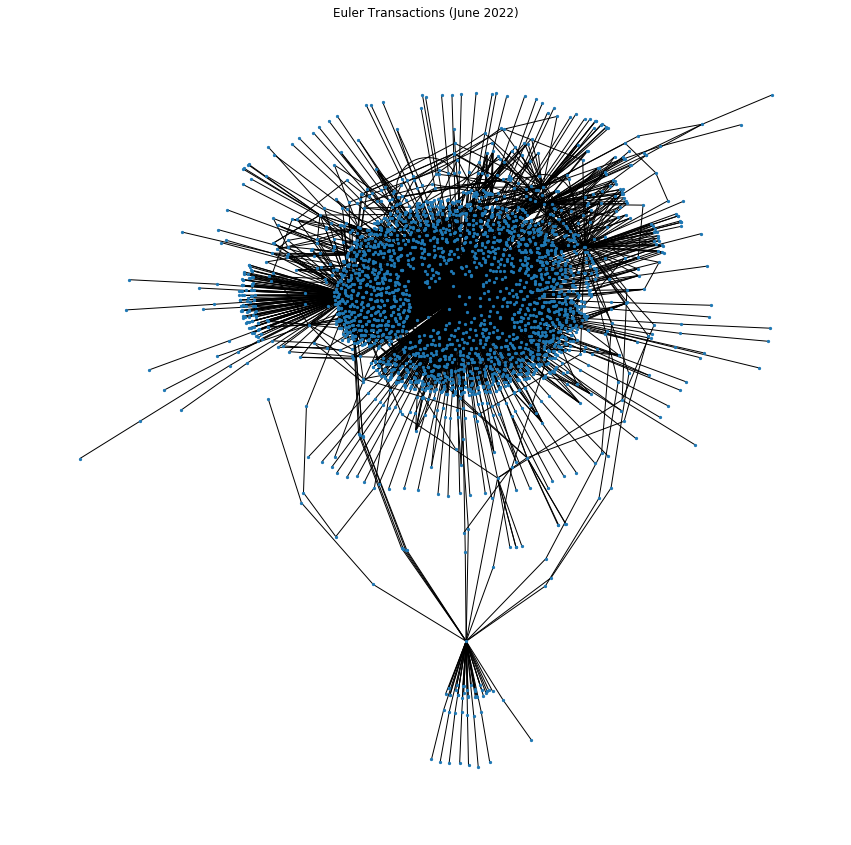

In [31]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (June 2022)')
nx.draw(june, with_labels=False, node_size=5)

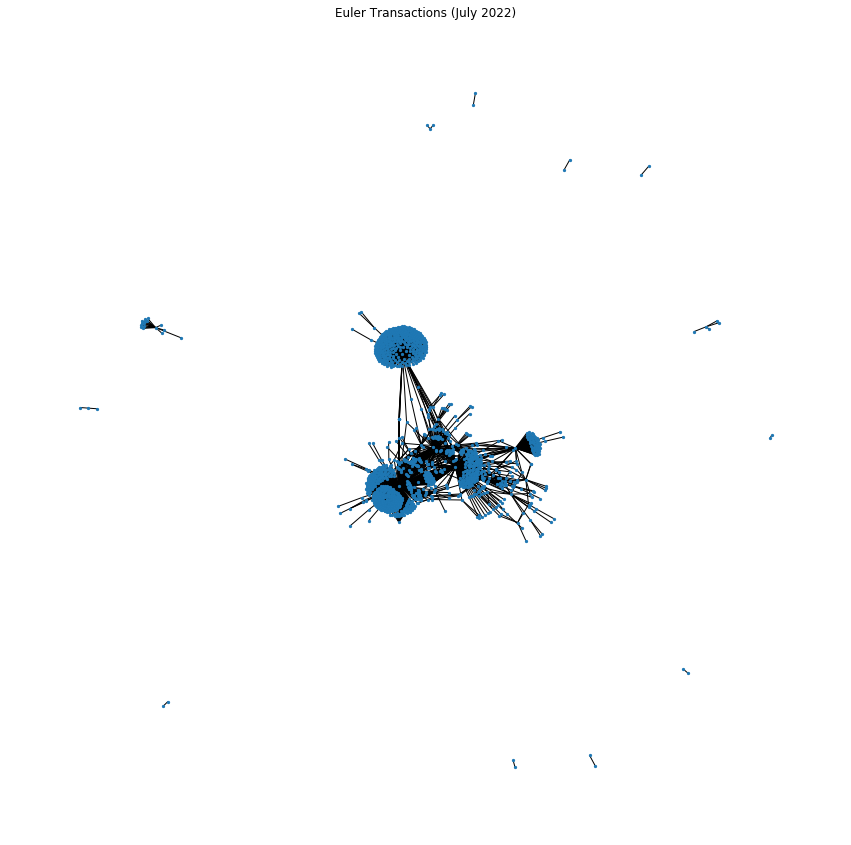

In [32]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (July 2022)')
nx.draw(july, with_labels=False, node_size=5)

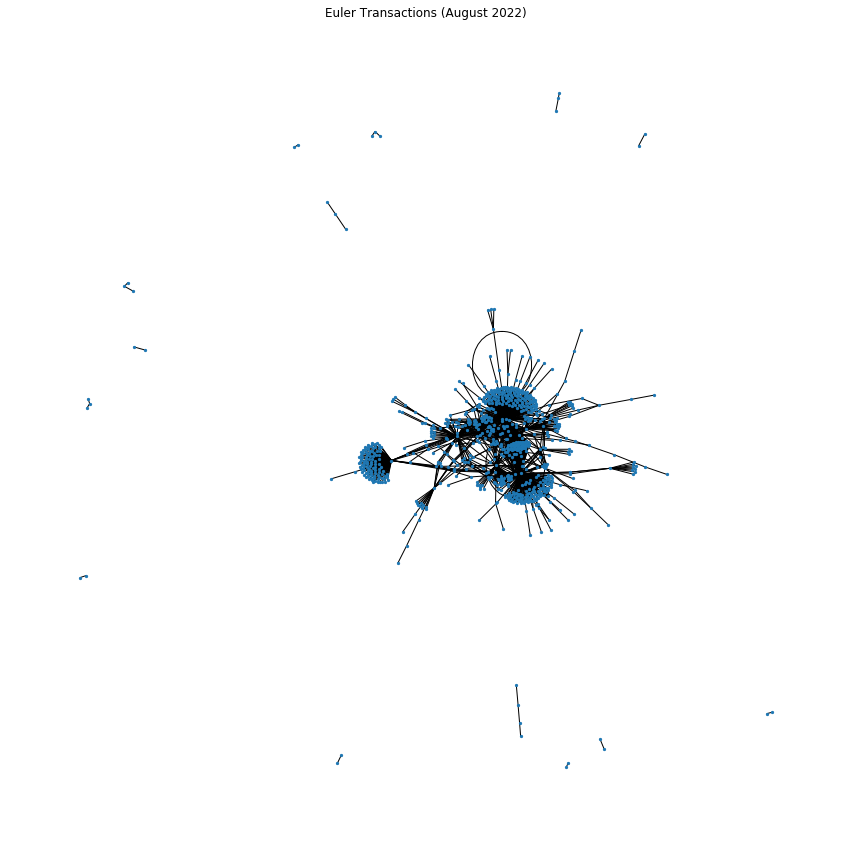

In [33]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (August 2022)')
nx.draw(august, with_labels=False, node_size=5)

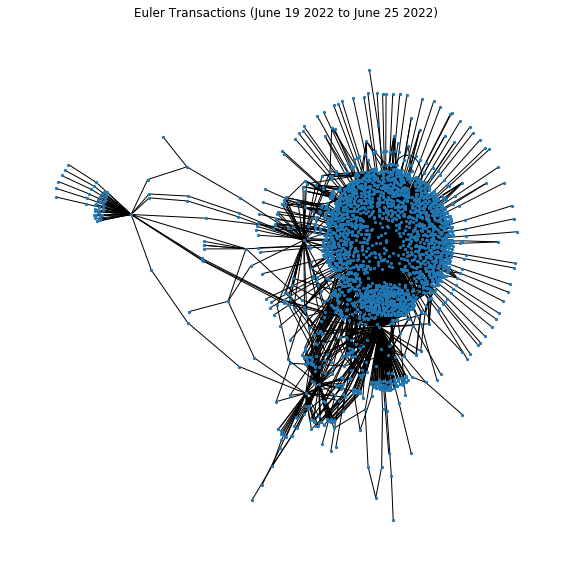

In [34]:
#network of June 19 2022 to June 25 2022 transactions

plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (June 19 2022 to June 25 2022)')
nx.draw(week1, with_labels=False, node_size=10)

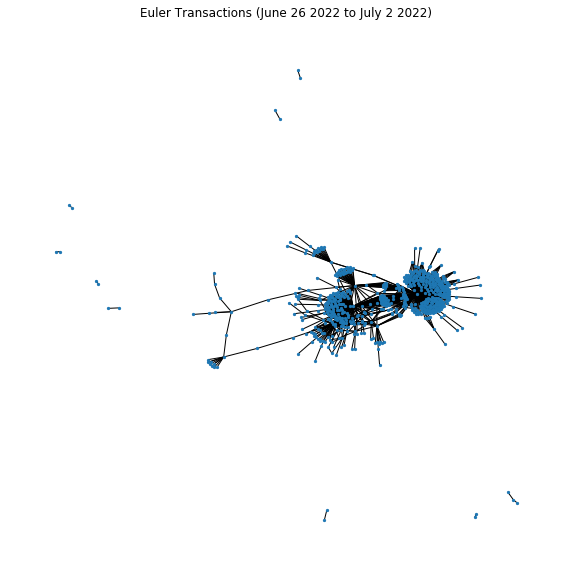

In [35]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (June 26 2022 to July 2 2022)')
nx.draw(week2, with_labels=False, node_size=10)

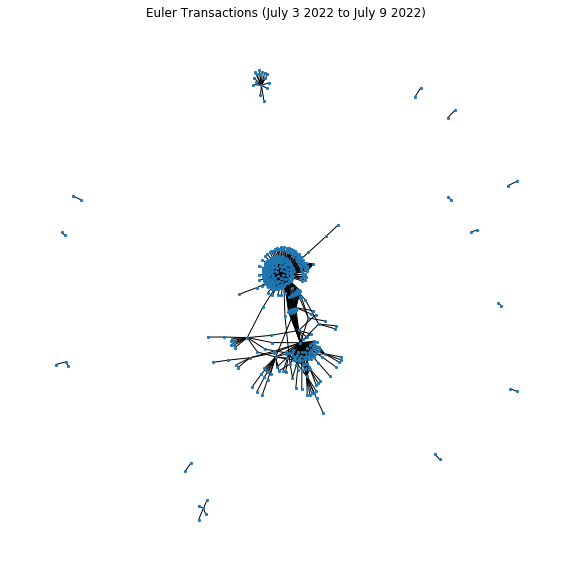

In [36]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (July 3 2022 to July 9 2022)')
nx.draw(week3, with_labels=False, node_size=10)

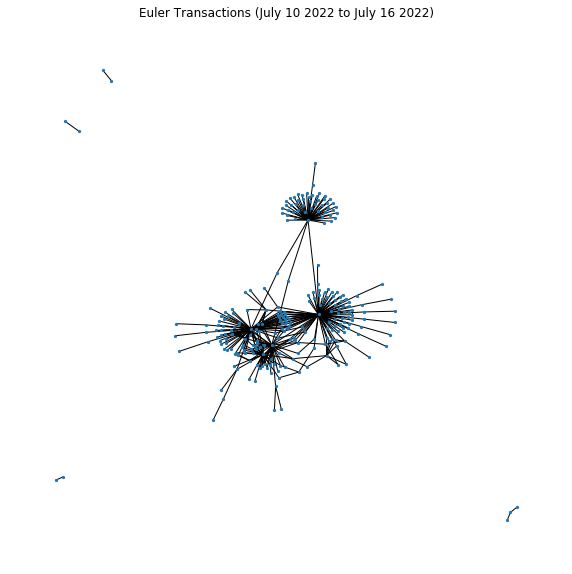

In [37]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (July 10 2022 to July 16 2022)')
nx.draw(week4, with_labels=False, node_size=10)

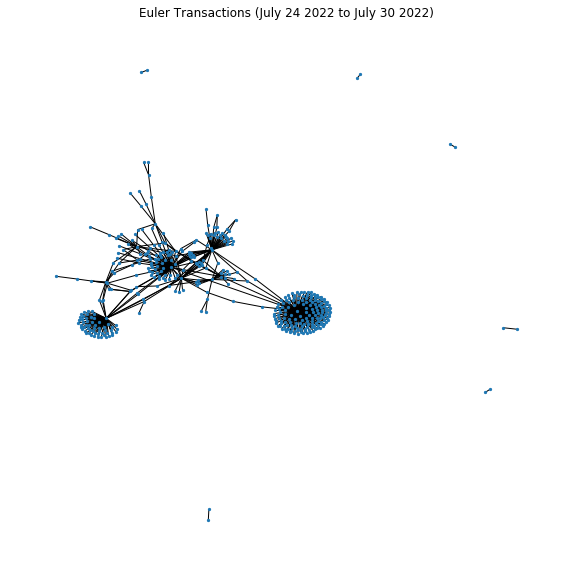

In [38]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (July 24 2022 to July 30 2022)')
nx.draw(week5, with_labels=False, node_size=10)

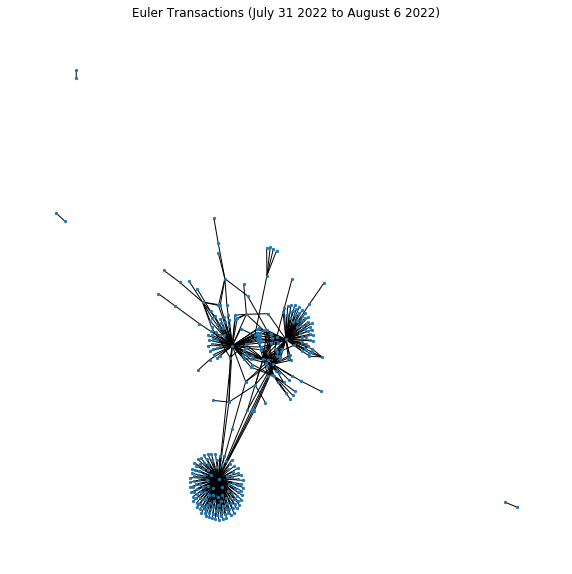

In [39]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (July 31 2022 to August 6 2022)')
nx.draw(week6, with_labels=False, node_size=10)

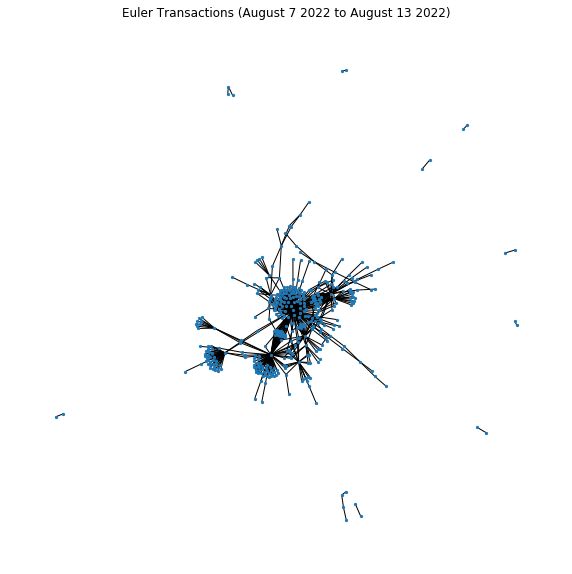

In [40]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (August 7 2022 to August 13 2022)')
nx.draw(week7, with_labels=False, node_size=10)

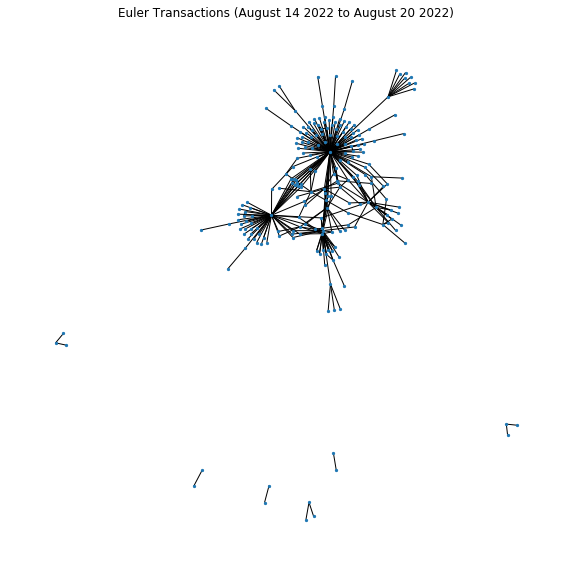

In [41]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (August 14 2022 to August 20 2022)')
nx.draw(week8, with_labels=False, node_size=10)

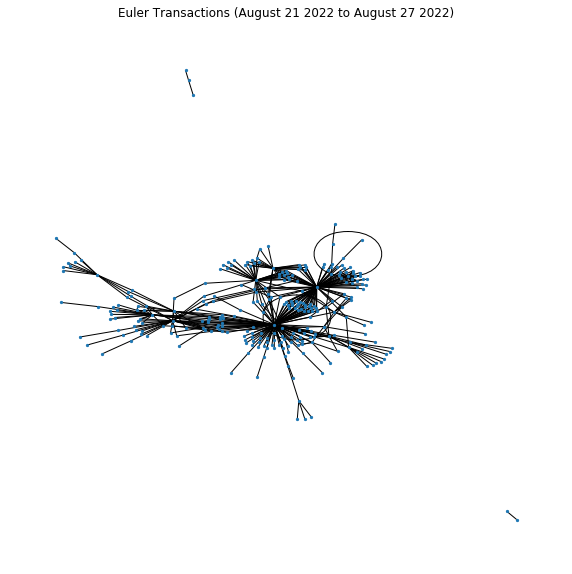

In [42]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (August 21 2022 to August 27 2022)')
nx.draw(week9, with_labels=False, node_size=5)

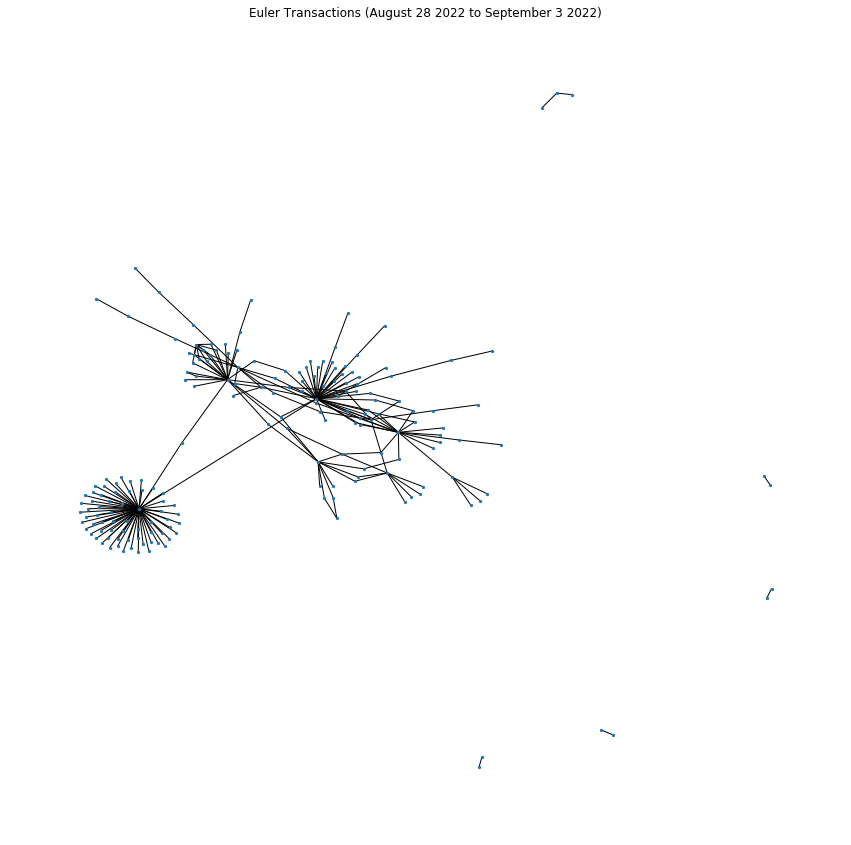

In [43]:
plt.figure(figsize=(15, 15))
plt.title('Euler Transactions (August 28 2022 to September 3 2022)')
nx.draw(week10, with_labels=False, node_size=10)